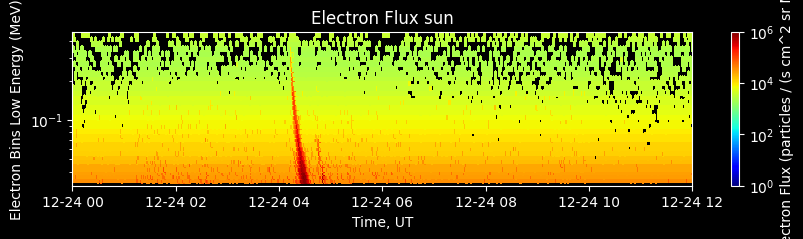

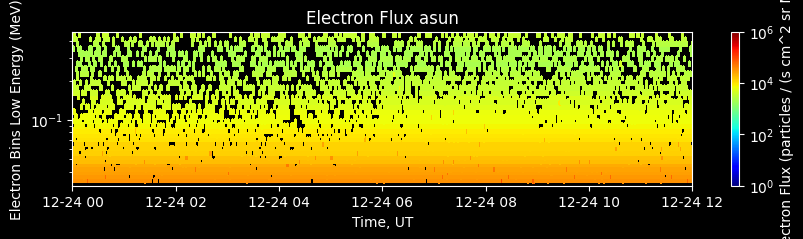

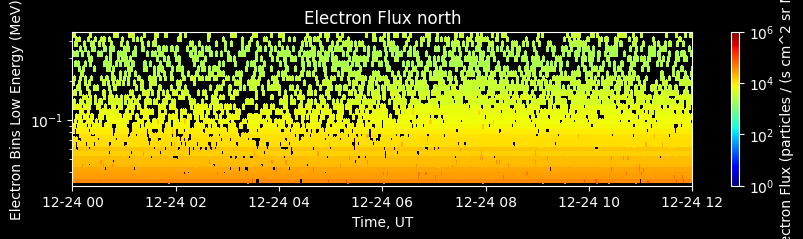

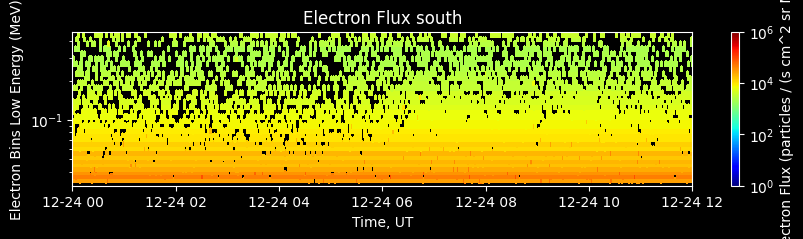

In [12]:
from spacepy import pycdf  # Import pycdf module from SpacePy library
import numpy as np  # Import Numpy library
import matplotlib.pyplot as plt  # Import Matplotlib library
# %matplotlib inline #uncomment if the plots do not appear
import datetime as dt
import numpy
import os
from matplotlib import pyplot as plt
from solo_epd_loader import epd_load, _autodownload_cdf, get_available_soar_files
from spectro import spectro_plot

# define start and end date of data to load (year, month, day):
startdate = dt.datetime(2022, 12, 24)
enddate = dt.datetime(2022, 12, 24)
sensor = 'ept'
level = 'l2'
vmin = 1
vmax = 1000000
viewings = ['sun', 'asun', 'north', 'south']  # 'sun', 'asun', 'north', 'south'
particles = ['Electron']  # 'Electron', 'Ion', 'Alpha'
accessors = ['Flux']  # 'Rate', 'Flux', 'Uncertainty'

startdate_str = f"{startdate.strftime('%Y%m%d')}"
enddate_str = f"{enddate.strftime('%Y%m%d')}"
# create folder if not exists corresponding to the date
path = f"{os.getcwd()}/data/main/{startdate_str}-{enddate_str}/"
csv_path = f"{path}/csv/"


def init_folders():
    if not os.path.exists(path):
        os.makedirs(path)
    if not os.path.exists(csv_path):
        os.makedirs(csv_path)
    # clean the folder csv_path
    # for file in os.listdir(csv_path):
    #    os.remove(os.path.join(csv_path, file))


init_folders()


def process_particle(particle):
    for flux_accessor in accessors:
        flux_accessor_ = f'{particle}_{flux_accessor}'
        time_accessor_ = cdfs[0][flux_accessor_].attrs['DEPEND_0']
        energy_accessor_ = cdfs[0][flux_accessor_].attrs['DEPEND_1']

        energies = numpy.array([cdf[energy_accessor_][...] for cdf in cdfs])
        width_accessor_ = f'{particle}_Bins_Width'
        width = numpy.array([cdf[width_accessor_][...] for cdf in cdfs])
        sum_last_items = energies[0, -1] + width[0, -1]
        energies = numpy.append(energies, [[sum_last_items]], axis=1)

        if not energies.all():
            print("All energy levels are NOT equal")

        time = numpy.array([], dtype='datetime64[s]')
        energy = energies[0]
        flux = numpy.empty((0, len(energy) - 1))
        for cdf in cdfs:
            time_tmp = numpy.array(cdf[time_accessor_][...], dtype='datetime64[s]')
            time_tmp = time_tmp[time_tmp < numpy.datetime64('2022-12-24T12:00:01')]

            time = numpy.concatenate([time, time_tmp])
            flux = numpy.concatenate((flux, cdf[flux_accessor_][...][:time_tmp.size]), axis=0)

        # replace all values less than 0 with 0
        flux[flux < 0] = 0

        numpy.savetxt(f"{csv_path}/energy.txt", energy, delimiter=',')
        numpy.savetxt(f"{csv_path}/time.txt", time, delimiter=',', fmt='%s')
        numpy.savetxt(f"{csv_path}/flux.txt", flux, delimiter=',')
        #
        # flux = np.loadtxt(f"{csv_path}/energy.txt", delimiter=',')
        # time = np.loadtxt(f"{csv_path}/time.txt", delimiter=',', dtype='datetime64')
        # energy = np.loadtxt(f"{csv_path}/flux.txt", delimiter=',')

        #### Plot using the "spectro" function with input parameters "eflux", "time", and "(energy) channels" ####

        ax = spectro_plot(flux, time,
                          channels=energy,
                          xlabel="Time, UT",
                          ylabel=f"{cdfs[0][energy_accessor_].attrs['FIELDNAM']} ({cdfs[0][energy_accessor_].attrs['UNITS']})",
                          zlabel=f"{cdfs[0][flux_accessor_].attrs['FIELDNAM']} ({cdfs[0][flux_accessor_].attrs['UNITS']})",
                          yscale="log",
                          figsize=(10, 2),
                          cmap="jet",
                          vmin=vmin, vmax=vmax,
                          lognorm=True
                          )
        ax.set_title(f'{particle} {flux_accessor} {viewing}')


for viewing in viewings:
    _autodownload_cdf(sensor=sensor, level=level, startdate=startdate_str, enddate=enddate_str, path=path)
    files = get_available_soar_files(sensor=sensor, level=level, startdate=startdate_str, enddate=enddate_str)

    # select only files with matching viewing
    files = [file for file in files if viewing == file.split('-')[2]]
    cdfs = [pycdf.CDF(f"{path}{file}") for file in files]
    for particle in particles:
        process_particle(particle)

plt.show()

#input("Press Enter to continue...")

for cdf in cdfs:
    cdf.close()
